# Setup

In [1]:
from matplotlib import pyplot as plt
import cv2
import numpy as np

In [2]:
def display(image):
    dpi = 80
    height, width = image.shape[:2]
    scale_factor = 0.2
    width_scaled = width * scale_factor
    height_scaled = height * scale_factor
    
    figsize = width_scaled / float(dpi), height_scaled / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(image, cmap='gray')
    plt.show()

# Preprocessing

In [63]:
def apply_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def apply_filter(img):
    gray = apply_gray(img)
    kernel = np.ones((5, 5), np.float32) / 15
    filtered = cv2.filter2D(gray, -1, kernel)
    return filtered

def apply_threshold(filtered):
    thresh = cv2.threshold(filtered, 250, 255, cv2.THRESH_OTSU)[1]
    return thresh

def detect_contour(img, img_shape):
    canvas = np.zeros(img_shape, np.uint8)
    contours, hierarchy = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    cnt = sorted(contours, key=cv2.contourArea, reverse=True)[0]
    cv2.drawContours(canvas, cnt, -1, (0, 255, 255), 3)
    return canvas, cnt

def detect_corners(canvas, cnt):
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx_corners = cv2.approxPolyDP(cnt, epsilon, True)
    cv2.drawContours(canvas, approx_corners, -1, (255, 255, 0), 10)
    approx_corners = sorted(np.concatenate(approx_corners).tolist())
    approx_corners = [approx_corners[i] for i in [0, 2, 1, 3]]
    approx_corners = np.array(approx_corners)
    approx_corners = approx_corners.reshape((4, 2))
    new_approx_corners = np.zeros((4, 1, 2), dtype=np.int32)
    add = approx_corners.sum(1)

    new_approx_corners[0] = approx_corners[np.argmin(add)]
    new_approx_corners[3] = approx_corners[np.argmax(add)]
    diff = np.diff(approx_corners, axis=1)
    new_approx_corners[1] = approx_corners[np.argmin(diff)]
    new_approx_corners[2] = approx_corners[np.argmax(diff)]

    result_list = [sublist[0].tolist() if sublist.size > 0 else [] for sublist in new_approx_corners]
    return result_list

def get_destination_points(corners):
    w1 = np.sqrt((corners[0][0] - corners[1][0]) ** 2 + (corners[0][1] - corners[1][1]) ** 2)
    w2 = np.sqrt((corners[2][0] - corners[3][0]) ** 2 + (corners[2][1] - corners[3][1]) ** 2)
    w = max(int(w1), int(w2))

    h1 = np.sqrt((corners[0][0] - corners[2][0]) ** 2 + (corners[0][1] - corners[2][1]) ** 2)
    h2 = np.sqrt((corners[1][0] - corners[3][0]) ** 2 + (corners[1][1] - corners[3][1]) ** 2)
    h = max(int(h1), int(h2))

    destination_corners = np.float32([(0, 0), (w - 1, 0), (0, h - 1), (w - 1, h - 1)])

    return destination_corners, h, w

def unwarp(img, src, dst):
    h, w = img.shape[:2]
    H, _ = cv2.findHomography(src, dst, method=cv2.RANSAC, ransacReprojThreshold=3.0)
    un_warped = cv2.warpPerspective(img, H, (w, h), flags=cv2.INTER_LINEAR)
    return un_warped

def resize_image(image, target_size=(2500, 2000)):
    return cv2.resize(image, target_size)

def match_template(image, template):
    result = cv2.matchTemplate(image, template, cv2.TM_CCOEFF)

    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)

    h, w = template.shape
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(image, top_left, bottom_right, (0, 255, 0), 2)
    return top_left[0], top_left[1]

def crop_image(image, coord):
    x, y, w, h = coord[0], coord[1], coord[2], coord[3]
    return image[y:y + h, x:x + w]

In [74]:
image = cv2.imread('images/img14.jpg')
template = cv2.imread("images/logo.jpg")

filtered_image = apply_filter(image)
threshold_image = apply_threshold(filtered_image)

cnv, largest_contour = detect_contour(threshold_image, image.shape)
corners = detect_corners(cnv, largest_contour)

destination_points, h, w = get_destination_points(corners)
un_warped = unwarp(image, np.float32(corners), destination_points)
cropped = un_warped[0:h, 0:w]
gray = apply_gray(cropped)
thresh = apply_threshold(gray)
resize = resize_image(thresh)

gray_template_image = apply_gray(template)
thresh_template_image = apply_threshold(gray_template_image)
x, y = match_template(resize, thresh_template_image)

usage_text_image = crop_image(resize, (x - 100, y + 500, 2200, 350))
drug_name_text_image = crop_image(resize, (x - 100, y + 1300, 2200, 200))

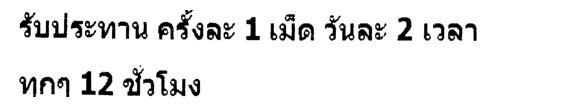

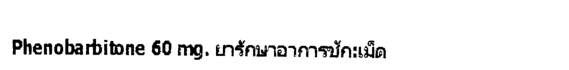

In [75]:
display(usage_text_image)
display(drug_name_text_image)

# OCR

In [76]:
import pytesseract as tess

In [77]:
def ocr(image, config):
    return tess.image_to_string(image, config=config)

In [78]:
usage_config = '--oem 3 --psm 6 -l tha'
drug_name_config = '--oem 3 --psm 6 -l tha+eng'

usage_text = ocr(usage_text_image, usage_config)
drug_name_text = ocr(drug_name_text_image, drug_name_config)

In [79]:
print(usage_text)
print(drug_name_text)

รับประทาน ครั้งละ 1 เม็ด วันละ 2 เวลา
ทุกๆ 12 ชั่วโมง

Phenobarbitone 60 mg. ยารักษาอาการชัก:เม็ด



# Extract data

In [84]:
import re

In [85]:
def _clean_text(text):
    res = ''
    for line in text.splitlines():
        if line == '':
            continue
        res = res + line + ' '
    return res.strip()


def _check_period(text):
    keywords = ['เช้า', 'กลางวัน', 'เย็น', 'ก่อนนอน']
    res = {'เช้า': False, 'กลางวัน': False, 'เย็น': False, 'ก่อนนอน': False}
    period_type = False

    for keyword in keywords:
        found = re.search(keyword, text)
        if found:
            period_type = True
            res[keyword] = True

    if period_type:
        return res
    return None


def _check_hour(text):
    pattern = r'.+ ทุกๆ (\d+) (.+)'
    match = re.search(pattern, text)

    if match is None:
        return None

    num = match.group(1)
    unit = match.group(2)
    return {'num': num, 'unit': unit}


def _check_frequency(text):
    keywords = ['วันเว้นวัน']
    dict = {'วันเว้นวัน': 'every other day'}

    for keyword in keywords:
        found = re.search(keyword, text)
        if found:
            return dict[keyword]
    return None


def extract_data(drug_name_text, usage_text):
    drug_name = _clean_text(drug_name_text)
    usage = _clean_text(usage_text)
    res = {'drug_name': drug_name, 'drug_usage': usage, 'reminder_type': '', 'frequency': 'every day'}

    freq = _check_frequency(usage)
    if freq:
        res['frequency'] = freq

    ok = _check_period(usage)
    if ok:
        user_time_settings = {'morning': '2024-03-25T08:00:00+07:00', 'noon': '2024-03-25T12:00:00+07:00', 'evening': '2024-03-25T16:00:00+07:00', 'before_bed': '2024-03-25T20:00:00+07:00'}
        res['reminder_type'] = 'period'
        if ok['เช้า']:
            res['morning'] = user_time_settings['morning']
        else:
            res['morning'] = None
        if ok['กลางวัน']:
            res['noon'] = user_time_settings['noon']
        else:
            res['noon'] = None
        if ok['เย็น']:
            res['evening'] = user_time_settings['evening']
        else:
            res['evening'] = None
        if ok['ก่อนนอน']:
            res['before_bed'] = user_time_settings['before_bed']
        else:
            res['before_bed'] = None
        return res

    ok = _check_hour(usage)
    if ok:
        res['reminder_type'] = 'hour'
        res['every'] = ok['num']
        return res
    return None


In [86]:
res = extract_data(drug_name_text, usage_text)

In [87]:
print(res)

{'drug_name': 'Phenobarbitone 60 mg. ยารักษาอาการชัก:เม็ด', 'drug_usage': 'รับประทาน ครั้งละ 1 เม็ด วันละ 2 เวลา ทุกๆ 12 ชั่วโมง', 'reminder_type': 'hour', 'frequency': 'every day', 'every': '12'}
